# Pittsburgh “Best Neighborhood” – CSV-only Check-in Notebook

## 1) Smart Trash Containers — neighborhood counts & quick score

In [2]:
# --- CONFIG ---
CSV_PATH = "LOCAL_SMART_TRASH_CSV_PATH.csv"
GROUP_COL = "auto"  # "auto" | column name | None

# Output paths
OUT_DIR = Path("../outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("../figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 140

def zscore(s):
    s = pd.to_numeric(s, errors='coerce')
    mu, sd = s.mean(), s.std(ddof=0)
    if sd == 0 or pd.isna(sd):
        return pd.Series(0, index=s.index)
    return (s - mu) / sd

def summarize_missing(df):
    miss = df.isna().mean().sort_values(ascending=False)
    return miss[miss > 0]


### Load CSV & inspect

In [3]:
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), " Columns:", len(df.columns))
display(df.head(3))
print("\nDtypes:\n", df.dtypes)
print("\nMissingness (top):\n", summarize_missing(df).head(15))


Rows: 1194  Columns: 17


,_id,container_id,receptacle_model_id,assignment_date,last_updated_date,group_name,address,city,state,zip,neighborhood,dpw_division,council_district,ward,fire_zone,x,y
0,385243,1,74,2017-09-14T13:24:40,2022-11-24T13:17:19,1st Division,122 E North Ave,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,1-6,-80.004018,40.456073
1,385244,2,74,2017-09-14T13:24:40,2022-12-31T01:54:25,1st Division,2507 Brighton Rd,Pittsburgh,Pennsylvania,15212,Marshall-Shadeland,1.0,1.0,27.0,1-9,-80.025132,40.467213
2,385245,3,74,2017-09-14T13:24:40,2022-04-14T01:59:18,1st Division,1300 Federal St,Pittsburgh,Pennsylvania,15212,Central Northside,1.0,1.0,22.0,1-6,-80.006872,40.456625



Dtypes:
 _id                      int64
container_id             int64
receptacle_model_id      int64
assignment_date         object
last_updated_date       object
group_name              object
address                 object
city                    object
state                   object
zip                      int64
neighborhood            object
dpw_division           float64
council_district       float64
ward                   float64
fire_zone               object
x                      float64
y                      float64
dtype: object

Missingness (top):
 ward                0.000838
dpw_division        0.000838
council_district    0.000838
neighborhood        0.000838
dtype: float64


### Detect neighborhood column (or set manually)

In [4]:
candidates = [c for c in df.columns if str(c).lower() in ["neighborhood","hood","community","neighbourhood"]]
if GROUP_COL == "auto":
    GROUP_COL = candidates[0] if candidates else None
print("Detected GROUP_COL:", GROUP_COL)


Detected GROUP_COL: neighborhood


### Aggregate to neighborhood (if available)

,neighborhood,smart_trash_count,smart_trash_z
57,Shadyside,76,3.699491
25,East Liberty,68,3.213505
66,Squirrel Hill South,63,2.909764
8,Bloomfield,58,2.606023
48,North Shore,53,2.302281
61,South Side Flats,51,2.180785
69,Strip District,42,1.634051
13,Carrick,38,1.391058
17,Central Oakland,34,1.148065
15,Central Lawrenceville,29,0.844324


Saved: ..\outputs\smart_trash_by_neighborhood.csv


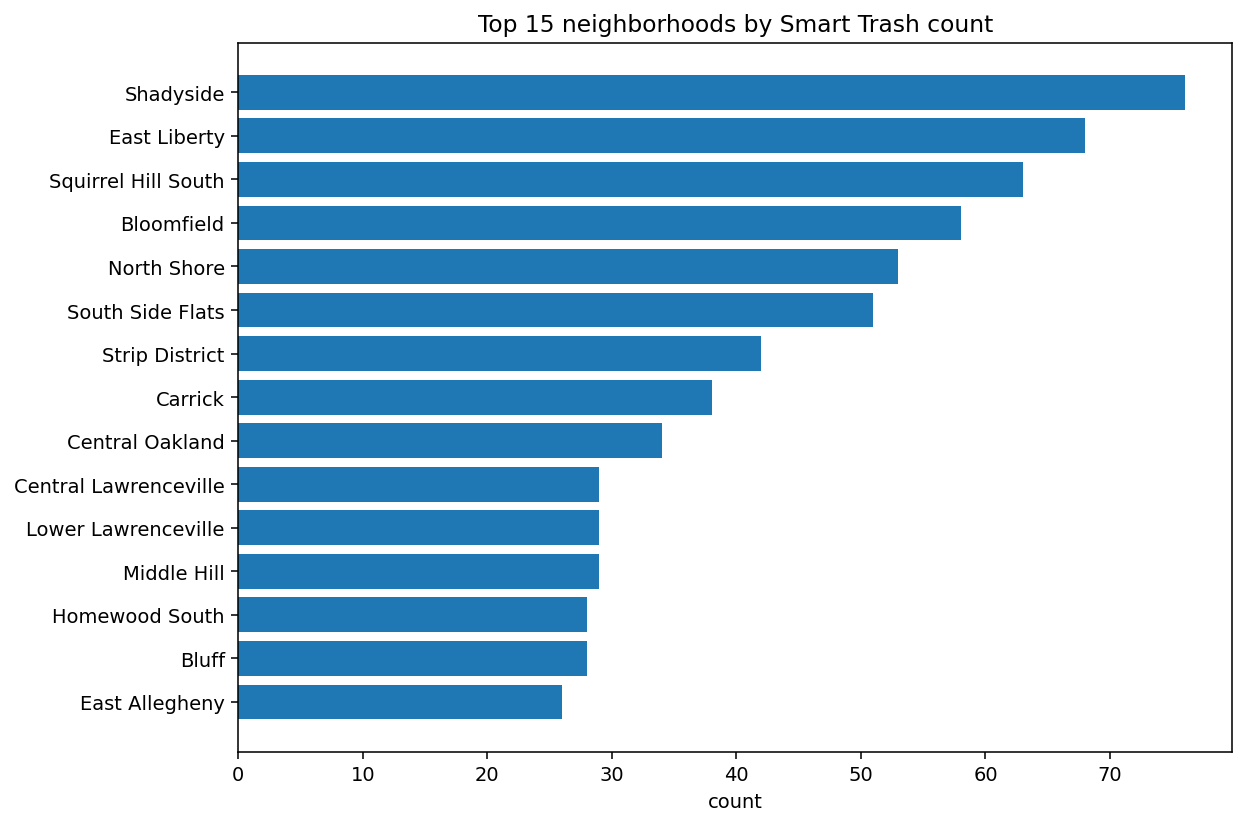

Saved figure: ..\figures\top15_smart_trash.png


In [5]:
if GROUP_COL is not None and GROUP_COL in df.columns:
    grp = (df.groupby(GROUP_COL).size()
           .rename("smart_trash_count").reset_index()
           .rename(columns={GROUP_COL: "neighborhood"}))
    grp["smart_trash_z"] = zscore(grp["smart_trash_count"])
    grp = grp.sort_values("smart_trash_z", ascending=False)
    display(grp.head(10))

    # Save
    out_csv = OUT_DIR / "smart_trash_by_neighborhood.csv"
    grp.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # Plot
    top = grp.head(15)
    plt.figure(figsize=(9,6))
    plt.barh(top["neighborhood"], top["smart_trash_count"])
    plt.gca().invert_yaxis()
    plt.title("Top 15 neighborhoods by Smart Trash count")
    plt.xlabel("count")
    plt.tight_layout()
    fig_path = FIG_DIR / "top15_smart_trash.png"
    plt.savefig(fig_path, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved figure:", fig_path)
else:
    print("No neighborhood-like column found. You can still proceed for overall stats, "
          "or later add neighborhoods via a spatial join (GeoPandas).")
    # basic overall stats
    print("Overall rows:", len(df))
